In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import re 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [257]:
import chardet
with open('startup_funding.csv', 'rb') as f:
    result = chardet.detect(f.read())

In [258]:
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [259]:
df = pd.read_csv('startup_funding.csv',encoding='Windows-1252')

In [260]:
df.head(5)

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,3030,22/01//2015,Corporate360,NaN,NaN,NaN,Group of Angel Investors,Seed Funding,"2,00,000",NaN
1,3012,15/01.2015,Wishberry,NaN,NaN,NaN,"Rajan Anandan, Shankar Mahadevan, Deep Kalra &...",Seed Funding,"6,50,000",NaN
2,2832,13/04.2015,The Porter,Logistics Tech,NaN,Mumbai,Kae Capital,Seed Funding,"5,00,000",NaN
3,2776,12/05.2015,Mobiefit,Mobile Fitness App,NaN,Goa,Prototyze,Seed Funding,NaN,NaN
4,2777,12/05.2015,Plancess,Online Education Platform,NaN,Mumbai,"Rajendra Gogri,\\xc2\\xa0 Chandrakant Gogri",Seed Funding,"20,00,000",NaN


In [261]:
df.shape

(3044, 10)

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sr No              3044 non-null   int64 
 1   Date dd/mm/yyyy    3044 non-null   object
 2   Startup Name       3044 non-null   object
 3   Industry Vertical  2873 non-null   object
 4   SubVertical        2108 non-null   object
 5   City  Location     2864 non-null   object
 6   Investors Name     3020 non-null   object
 7   InvestmentnType    3040 non-null   object
 8   Amount in USD      2084 non-null   object
 9   Remarks            419 non-null    object
dtypes: int64(1), object(9)
memory usage: 237.9+ KB


In [263]:
pd.DataFrame((df.isnull().sum()/len(df)*100).sort_values(ascending = False).round(2),columns=['Null %'])

,Null %
Remarks,86.24
Amount in USD,31.54
SubVertical,30.75
City Location,5.91
Industry Vertical,5.62
Investors Name,0.79
InvestmentnType,0.13
Sr No,0.00
Date dd/mm/yyyy,0.00
Startup Name,0.00


In [264]:
df.isnull().sum()

Sr No                   0
Date dd/mm/yyyy         0
Startup Name            0
Industry Vertical     171
SubVertical           936
City  Location        180
Investors Name         24
InvestmentnType         4
Amount in USD         960
Remarks              2625
dtype: int64

In [265]:
#Remarks is an unnecessary column. So, we remove it.
df = df.drop(columns = 'Remarks')

#Similarly we do away with Sr No.
df = df.drop(columns = 'Sr No')

In [266]:
df['Amount in USD'].describe()

count          2084
unique          470
top       10,00,000
freq            165
Name: Amount in USD, dtype: object

In [267]:
# Clean target column
df = df.applymap(lambda x: x.replace(r'\\xc2\\xa0', '') if type(x) == str else x)
df['Amount in USD'] = df['Amount in USD'].apply(lambda x: x.replace(',', '') if str(x) != 'nan' else x)
df['Amount in USD'] = df['Amount in USD'].replace({
    'undisclosed': np.NaN,
    'unknown': np.NaN,
    'Undisclosed': np.NaN,
    'N/A': np.NaN,
    '14342000+': '14342000'
})

In [268]:
df['Amount in USD'].unique()

array(['200000', '650000', '500000', nan, '2000000', '630000', '600000',
       '8048394', '9000000', '150000000', '200000000', '18358860',
       '3000000', '1800000', '231000000', '12000000', '30000000',
       '5900000', '20000000', '6000000', '50000000', '70000000',
       '1000000000', '17411265', '135000000', '220000000', '15800000',
       '26000000', '283000000', '486000', '1500000', '1300000', '300000',
       '45000000', '585000000', '4500000', '3300000', '5000000',
       '18000000', '1000000', '10000000', '450000000', '3900000000',
       '37000000', '110000000', '15000000', '6590000', '11000000',
       '51000000', '125000000', '1600000', '140000000', '38080000',
       '60000000', '16000000', '5750000', '2500000', '319605', '19000000',
       '145000', '430200', '15500000', '3584000', '2739035', '15109500',
       '52000000', '75000000', '3400000', '4889976', '5600000',
       '11500000', '868600', '14342000', '3591375', '17000000', '3500000',
       '430665', '6320820', 

In [269]:
#Drop missing target rows
missing_target_rows = df[df['Amount in USD'].isna()].index
df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)

In [270]:
# Fill categorical missing values with most frequent occurence
for column in ['Industry Vertical', 'City  Location', 'InvestmentnType']:
    df[column] = df[column].fillna(df[column].mode()[0])

In [271]:
# Convert target column to float
df['Amount in USD'] = df['Amount in USD'].astype(np.float)

In [272]:
# Fill the missing values with Others.
df['Industry Vertical'] = df['Industry Vertical'].fillna('Others')
df['SubVertical'] = df['SubVertical'].fillna('Others')
df['Industry Vertical'].value_counts()

Consumer Internet                                    720
Technology                                           310
eCommerce                                            126
Finance                                               57
Healthcare                                            44
                                                    ... 
Public Commute helper App                              1
proximity marketing & Mobile Advertising platform      1
Document Digitization platform                         1
Competitive exam learning platform                     1
Location Based App                                     1
Name: Industry Vertical, Length: 590, dtype: int64

As you can see there are various duplicate entries like E-Commerce, ECommerce etc.
We need to consolidate such Entries into single group.

In [273]:
# Step 1

# Convert all the values to upper case to avoid confusion
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: x.upper())

# Replace & with 'AND'
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: x.replace('&','AND'))

# A lot of values have \\XA2 replace them with ''
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: re.sub('\\\\[A-Z][A-Z][0-9]','',x))

# Now replace \ with ''
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: re.sub('\\\\',' ',x))

# Remove any unnecessary spaces.
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: x.replace('  ',''))

# Remove - 
df['Industry Vertical'] = df['Industry Vertical'].apply(lambda x: x.replace('-',''))

# We will be using sets for this purpose. I create a set which avoids repeated values.

def create_unique_Set(series):
    # We get all the values in series
    t_List = series.value_counts().index
    
    # We create an empty set to store unique values.
    t_Set = set()
    
    for i in t_List:
        r = re.compile('^{exp}'.format(exp = i.strip()))
        # We match the expression in i with values in temporary set to see if a similar value is already present.
        temp = list(filter(r.match, t_Set))
        if len(temp)>0:
        #If set has similar values we simply replace it with the longest value.    
            temp = [x for x in temp if len(x) == len(max(temp , key = len))]
            if len(temp[0]) < len(i):
                t_Set.remove(temp[0])
                t_Set.add(i)
        # If a match is not found we add the value in set.        
        elif len(temp) == 0 :
            t_Set.add(i)
    return t_Set    

        
# We am using the longest match function to replace similar values.

def find_longest_match(value, set_values):
    r = re.compile('^{val}'.format(val = value))
    # I match the value with values in our unique list.
    temp_list = list(filter(r.match , set_values))
    # We replace the current value with the longest value.
    temp = [x for x in temp_list if len(x) == len(max(temp_list, key = len))]
    # We return the longest value.
    if len(temp) > 0:
        temp = temp[0]
        return temp
    else:
        return value
# Create the set of unique values for data['Industry Vertical'] and eliminate duplicate values. 
set_iv = create_unique_Set(df['Industry Vertical'])      
df['Industry Vertical'] = df['Industry Vertical'].apply(find_longest_match , set_values = set_iv)  

df['Industry Vertical'].value_counts()


CONSUMER INTERNET                                       721
TECHNOLOGY                                              310
ECOMMERCE DISCOUNT AND CASHBACK COUPONS PLATFORM        206
FINANCE                                                  57
HEALTHCARE SERVICES DISCOVERY PLATFORM                   46
                                                       ... 
PERSONAL DIAGNOSTIC MOBILE APP                            1
ONLINE PAYMENT GATEWAY                                    1
PROFESSIONALS AND PROJECT SEARCH MARKETPLACE              1
ONLINE STUDENT AND CAMPUS SOCIAL NETWORKING PLATFORM      1
LOCATION BASED APP                                        1
Name: Industry Vertical, Length: 538, dtype: int64

We do the same thing for column, sub vertical.

In [274]:
# Step 1

# Convert all the values to upper case to avoid confusion
df['SubVertical'] = df['SubVertical'].apply(lambda x: x.upper())

# Replace & with 'AND'
df['SubVertical'] = df['SubVertical'].apply(lambda x: x.replace('&','AND'))

# A lot of values have \\XA2 replace them with ''
df['SubVertical'] = df['SubVertical'].apply(lambda x: re.sub('\\\\[A-Z][A-Z][0-9]','',x))

# Now replace \ with ''
df['SubVertical'] = df['SubVertical'].apply(lambda x: re.sub('\\\\',' ',x))

# Remove any unnecessary spaces.
df['SubVertical'] = df['SubVertical'].apply(lambda x: x.replace('  ',''))

# Remove - 
df['SubVertical'] = df['SubVertical'].apply(lambda x: x.replace('-',''))

# Remove NLOANS COMPARISON PLATFORMNNNN (ADSBYGOOGLE = WINDOW.ADSBYGOOGLE || []).PUSH({});NN with NLOANS COMPARISON PLATFORM
df['SubVertical'] = df['SubVertical'].apply(lambda x: re.sub(r'\([^()]*\)','',x))

# Create the set of unique values for data['Industry Vertical'] and eliminate duplicate values.
set_sv = create_unique_Set(df['SubVertical'])
df['SubVertical'] = df['SubVertical'].apply(find_longest_match , set_values = set_sv)  

df['SubVertical'].value_counts()

OTHERS                                                654
ONLINE LENDING PLATFORM FOR SALARIED PROFESSIONALS     25
ONLINE FOOD DELIVERY PLATFORM                           8
ONLINE LEARNING PLATFORM                                7
ONLINE PHARMACY AND HEALTH MARKETPLACE                  6
                                                     ... 
DIY ECOMMERCE PLATFORM                                  1
HEALTHCARE SERVICE AGGREGATOR                           1
PREDICTIVE CARE PLATFORM                                1
BEAUTY SERVICES MARKETPLACE                             1
CRAFT BEER MANUFACTURING COMPANY                        1
Name: SubVertical, Length: 1207, dtype: int64

In [275]:
# Check for null values
print("Null values are: " , len(df[df['City  Location'].isnull()]))

# Replace the Null values with others.
df['City  Location'] = df['City  Location'].fillna('OTHERS')

# We convert all values to uppercase for convineance.
df['City  Location'] = df['City  Location'].apply(lambda x: x.upper())

# The data has multiple cities seperated by /. So we remove the slash and pick one city. 
df['City  Location'].value_counts()

# We remove the slash and remove any excess space.
df['City  Location'] = df['City  Location'].apply(lambda x: x.split('/')[0].strip())

# We have to clean the data to avoid duplicity. 
df.loc[(df['City  Location'] == 'AHEMADABAD') | (df['City  Location'] == 'AHMEDABAD') , 'City  Location'] = 'AHMEDABAD'
df.loc[(df['City  Location'] == 'BANGALORE') | (df['City  Location'] == 'BENGALURU') , 'City  Location'] = 'BENGALURU'
df.loc[(df['City  Location'] == 'GURGAON') | (df['City  Location'] == 'GURUGRAM') , 'City  Location'] = 'GURUGRAM'

# Display the cleaned data.
df['City  Location']

Null values are:  0


0       BENGALURU
1       BENGALURU
2          MUMBAI
3          MUMBAI
4          MUMBAI
          ...    
2068    BENGALURU
2069    BENGALURU
2070    BENGALURU
2071    BENGALURU
2072    BENGALURU
Name: City  Location, Length: 2073, dtype: object

In [276]:
print(df['InvestmentnType'].value_counts(dropna = False))

# Function to remove the slash
def remove_Slash(investment):
    temp = investment
    if re.search('/', investment):
        temp = investment.split('/')[1].strip()        
    return temp.upper().strip()    


#Remove the null values with Private Equity as it is the most common values.
df['InvestmentnType'] = df['InvestmentnType'].fillna('Private Equity')

# Remove the \\n.
df['InvestmentnType'] = df['InvestmentnType'].apply(lambda x: re.sub(r'\\\\n' , ' ' , x))

# Convert all values to uppercase for convineance and remove the /.
df['InvestmentnType'] = df['InvestmentnType'].apply(remove_Slash)

# Change the values of seed and seed round to seed funding to avoid duplication.. 
df['InvestmentnType'][(df['InvestmentnType'] == 'SEED') | (df['InvestmentnType'] == 'SEED ROUND') | (df['InvestmentnType'] == 'SEED FUNDING ROUND')] = 'SEED FUNDING'

# Change angel round, angel and angle funding to angel funding to avoid duplication.
df['InvestmentnType'][(df['InvestmentnType'] == 'ANGEL') | (df['InvestmentnType'] == 'ANGEL ROUND') | (df['InvestmentnType'] == 'ANGLE FUNDING')] = 'ANGEL FUNDING'

# Change DEBT and DEBT-FUNDING to DEBT FUNDING to avoid duplication.
df['InvestmentnType'][(df['InvestmentnType'] == 'DEBT') | (df['InvestmentnType'] == 'DEBT-FUNDING') ] = 'DEBT FUNDING'

# Change EQUITY and EQUITY BASED FUNDING to EQUITY BASED FUNDING to avoid duplication.
df['InvestmentnType'][(df['InvestmentnType'] == 'EQUITY') | (df['InvestmentnType'] == 'EQUITY BASED FUNDING') ] = 'EQUITY BASED FUNDING'

# Change PRIVATE FUNDING, PRIVATEEQUITY , PRIVATE FUNDING ROUND and PRIVATE to PRIVATE EQUITY to avoid duplication.
df['InvestmentnType'][(df['InvestmentnType'] == 'PRIVATE FUNDING') | (df['InvestmentnType'] == 'PRIVATE EQUITY ROUND') | (df['InvestmentnType'] == 'PRIVATE') | (df['InvestmentnType'] == 'PRIVATEEQUITY') | (df['InvestmentnType'] == 'PRIVATE FUNDING ROUND')] = 'PRIVATE EQUITY'

Private Equity                 1074
Seed Funding                    718
Seed/ Angel Funding              48
Seed / Angel Funding             38
Debt Funding                     24
Series A                         22
Seed\\nFunding                   22
Series B                         20
Seed/Angel Funding               18
Series C                         14
Series D                         12
Seed Round                        7
Angel / Seed Funding              4
Private Equity Round              4
Seed                              4
Pre-Series A                      4
Equity                            2
Series F                          2
Venture Round                     2
pre-Series A                      2
Series E                          2
Seed / Angle Funding              2
Private Funding                   1
Mezzanine                         1
Series B (Extension)              1
Term Loan                         1
Structured Debt                   1
Equity Based Funding        

In [277]:
data = df.copy()

In [278]:
data = data.rename(columns={'Date dd/mm/yyyy': 'Date'})

In [279]:
data

,Date,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD
0,22/01//2015,Corporate360,CONSUMER INTERNET,OTHERS,BENGALURU,Group of Angel Investors,SEED FUNDING,200000.0
1,15/01.2015,Wishberry,CONSUMER INTERNET,OTHERS,BENGALURU,"Rajan Anandan, Shankar Mahadevan, Deep Kalra &...",SEED FUNDING,650000.0
2,13/04.2015,The Porter,LOGISTICS TECH PLATFORM,OTHERS,MUMBAI,Kae Capital,SEED FUNDING,500000.0
3,12/05.2015,Plancess,ONLINE EDUCATION PLATFORM,OTHERS,MUMBAI,"Rajendra Gogri, Chandrakant Gogri",SEED FUNDING,2000000.0
4,01/07/015,HandyHome,HYPERLOCAL ELECTRONICS REPAIR SERVICE,OTHERS,MUMBAI,"Bessemer Ventures, Kae Capital",SEED FUNDING,630000.0
...,...,...,...,...,...,...,...,...
2068,05/01/2015,Lookup,CONSUMER INTERNET,OTHERS,BENGALURU,"DeNA Co., Japan & Teruhide Sato (in Addition t...",SEED FUNDING,380000.0
2069,05/01/2015,#Fame,CONSUMER INTERNET,OTHERS,BENGALURU,TO THE NEW Ventures,PRIVATE EQUITY,10000000.0
2070,05/01/2015,Gympik,CONSUMER INTERNET,OTHERS,BENGALURU,"Tom Clausen, Rohan Ajila, Haldyn Glass",SEED FUNDING,135000.0
2071,02/01/2015,LensKart,CONSUMER INTERNET,OTHERS,BENGALURU,"TPG Growth, TR Capital, IDG Ventures",PRIVATE EQUITY,2150000.0


In [280]:
# First replace // with / and . with /.
data['Date'] = data['Date'].apply(lambda x: x.replace('//' , '/' ))
data['Date'] = data['Date'].apply(lambda x: x.replace('.' , '/' ))

# Showing the discrepancies in data.
print('Showing formats of date other than dd/mm/yyyy:')
for i in data['Date']:
    if not re.match(r'\b[0-9][0-9]/[0-9][0-9]/[0-9][0-9][0-9][0-9]' , i.strip()):
        print(i)
        
# As you can see incorrect formats for dates are d/mm/yyyy , dd/m/yyyy , d/m/yyyy or dd/mmyyyy.        
# We have to convert them into dd/mm/yyyy 
digits = []
# Function to put all date values in correct format.
def correct_date(date):
    global digits
    # Extract all the digits in form dd/mm/yyyy and store them in a list.
    if re.match(r'\b[0-9][0-9]/[0-1][0-9]/[0-9][0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(2,'/')
        digits.insert(5,'/')
        
    # Extract all the digits in form d/mm/yyyy and store them in a list.    
    elif re.match(r'\b[0-9]/[0-1][0-9]/[0-9][0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(0,'0')
        digits.insert(2,'/')
        digits.insert(5,'/')
        
    # Extract all the digits in form d/m/yyyy and store them in a list.    
    elif re.match(r'\b[0-9]/[0-9]/[0-9][0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(0,'0')
        digits.insert(2,'0')
        digits.insert(2,'/')
        digits.insert(5,'/')
    
    # Extract all the digits in form dd/m/yyyy and store them in a list.    
    elif re.match(r'\b[0-9][0-9]/[0-9]/[0-9][0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(2,'0')
        digits.insert(2,'/')
        digits.insert(5,'/')
        
    # Extract all the digits in form dd/mmyyyy and store them in a list.    
    elif re.match(r'\b[0-9][0-9]/[0-1][0-9][0-9][0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(2,'/')
        digits.insert(5,'/')
    
    # Extract all the digits in form dd/mm/yyyy and store them in a list.
    elif re.match(r'\b[0-9][0-9]/[0-1][0-9]/[0-9][0-9][0-9]' , date.strip()):
        digits = re.findall(r'\d' , date)
        digits.insert(2,'/')
        digits.insert(5,'/')
        digits.insert(6,'2')
    else:
        digits = date   
    date_temp = ''
#     print('date: ' , date)
    # Finally we form the date in correct format.
    for i in range(10):
        date_temp = date_temp + digits[i]
#     print('new date: ' , date_temp)    
    return date_temp    


Showing formats of date other than dd/mm/yyyy:
01/07/015
10/7/2015


In [281]:
# Since there are no null values in date we can go ahead and clean the data.
data['Date'] = data['Date'].apply(correct_date) 


In [282]:
data['Date'].unique()

array(['22/01/2015', '15/01/2015', '13/04/2015', '12/05/2015',
       '01/07/2015', '10/07/2015', '13/01/2020', '10/01/2020',
       '09/01/2020', '02/01/2020', '20/12/2019', '17/12/2019',
       '16/12/2019', '14/12/2019', '13/12/2019', '12/12/2019',
       '11/12/2019', '06/12/2019', '03/12/2019', '25/11/2019',
       '20/11/2019', '19/11/2019', '18/11/2019', '15/11/2019',
       '14/11/2019', '13/11/2019', '12/11/2019', '11/11/2019',
       '04/10/2019', '02/10/2019', '05/09/2019', '04/09/2019',
       '03/09/2019', '27/08/2019', '23/08/2019', '22/08/2019',
       '21/08/2019', '19/08/2019', '13/08/2019', '12/08/2019',
       '01/08/2019', '11/07/2019', '10/07/2019', '09/07/2019',
       '08/07/2019', '04/07/2019', '03/07/2019', '02/07/2019',
       '01/07/2019', '10/06/2019', '08/06/2019', '06/06/2019',
       '05/06/2019', '04/06/2019', '03/06/2019', '31/05/2019',
       '30/05/2019', '28/05/2019', '06/05/2019', '02/05/2019',
       '01/05/2019', '19/04/2019', '17/04/2019', '16/04

In [283]:
# Convert the data type as datetime 64 
data['Date']=pd.to_datetime(data['Date'],format="%d/%m/%Y")

In [284]:
# Check for null values.
print('Null values in Startup names are: ' , data['Startup Name'].isnull().sum())
print('Null values in Investor names are: ' , data['Investors Name'].isnull().sum())

# Replace the null values with anonymous.
data['Investors Name'][data['Investors Name'].isnull()] = 'Undisclosed Investor'

# Convert all the values to upper case to avoid confusion.
data['Investors Name'] = data['Investors Name'].apply(lambda x: x.upper())

# Replace & with 'AND'
data['Investors Name'] = data['Investors Name'].apply(lambda x: x.replace('&','AND'))

# A lot of values have \\XA2 replace them with ''
data['Investors Name'] = data['Investors Name'].apply(lambda x: re.sub('\\\\[A-Z][A-Z][0-9]','',x))

# Now replace \ with ''
data['Investors Name'] = data['Investors Name'].apply(lambda x: re.sub('\\\\',' ',x))

# Remove any unnecessary spaces.
data['Investors Name'] = data['Investors Name'].apply(lambda x: x.replace('  ',''))

# Remove - 
data['Investors Name'] = data['Investors Name'].apply(lambda x: x.replace('-',''))

#Display the unique values in Investors Name.
data['Investors Name'].value_counts()

Null values in Startup names are:  0
Null values in Investor names are:  20


UNDISCLOSED INVESTORS                                                                     64
UNDISCLOSED INVESTOR                                                                      40
GROUP OF ANGEL INVESTORS                                                                  16
SEQUOIA CAPITAL                                                                           13
INDIAN ANGEL NETWORK                                                                      13
                                                                                          ..
SIMI PACIFIC PTE                                                                           1
MALL INDUSTRIES DEVELOPMENT BANK OF INDIA (SIDBI)                                          1
GAURAV KACHRU, SUNDEEP SINGH SAHNI, JATIN ANEJA, ARUN MALHOTRA                             1
NIBHRANT SHAH, ANANDBIR SINGH, ANIRUDH SHETH, PRATIK SINGHI, VIKRAM MEHTA, MURALI NAIR     1
VENKAT VALLABHNENI, SUDHAKAR REDDY, SRINIVASA RAO PATURI              

In [285]:
# Create a unique set.
set_in = create_unique_Set(data['Investors Name'])
#Find the longest match.
data['Investors Name'] = data['Investors Name'].apply(find_longest_match, set_values = set_in)

# Since we have a number of investors we need to make a new column to define the number of investors.
def no_of_investors(value):
    if re.search(',',value):
        return len(value.split(','))
    else:
        return 1
data['No of Investors'] = data['Investors Name'].apply(no_of_investors)

In [286]:
# Remove .com to avoid confusion.
data['Startup Name'] = data['Startup Name'].apply(lambda x: re.sub('.com',' ',x))

# Convert all the values to upper case to avoid confusion.
data['Startup Name'] = data['Startup Name'].apply(lambda x: x.upper())

# Replace & with 'AND'
data['Startup Name'] = data['Startup Name'].apply(lambda x: x.replace('&','AND'))

# A lot of values have \\XA2 replace them with ''
data['Startup Name'] = data['Startup Name'].apply(lambda x: re.sub('\\\\[A-Z][A-Z][0-9]','',x))

# Now replace \ with ''
data['Startup Name'] = data['Startup Name'].apply(lambda x: re.sub('\\\\',' ',x))

# Remove any unnecessary spaces.
data['Startup Name'] = data['Startup Name'].apply(lambda x: x.replace('  ',''))

# Remove - 
data['Startup Name'] = data['Startup Name'].apply(lambda x: x.replace('-',''))

#Display the unique values in Investors Name.
data['Startup Name'].value_counts()

SWIGGY               8
OLA CABS             7
LENDINGKART          6
BLACKBUCK            6
PAYTM                5
                    ..
KAROMI               1
PAYTM MARKETPLACE    1
OHO SHOP             1
TYDY                 1
VIOLETSTREET         1
Name: Startup Name, Length: 1634, dtype: int64

In [287]:
# Create a unique set.
set_sn = create_unique_Set(data['Startup Name'])
#Find the longest match.
data['Startup Name'] = data['Startup Name'].apply(find_longest_match, set_values = set_sn)

#Display the cleaned data.
data['Startup Name'].value_counts()

OLA CABS                           11
SWIGGY                              8
URBANCLAP TECHNOLOGIES PVT. LTD     6
FLIPKART                            6
BLACKBUCK                           6
                                   ..
AIRZAAR                             1
YOURSTORY                           1
LEOPETRA                            1
IMAGINATE                           1
VIOLETSTREET                        1
Name: Startup Name, Length: 1574, dtype: int64

In [288]:
data.to_csv('data_modified2.csv',index=False,encoding='utf-8')

In [289]:
# First we find out the monthly increase in data.

# Create a df to store the fund values.
col = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June' , 'July' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec']
fund_year = [2015,2016,2017,2018,2019,2020]
fund_df = pd.DataFrame(columns=col , index=fund_year)

# Set the default values as zero
fund_df[fund_df[::].isnull()] = 0

fund_df_temp = pd.DataFrame(columns= ['Year' , 'Month' , 'Amount in USD'] )

# Store the month wise funding recieved in the df.    
for i,v in data.iterrows():
    mn = v['Date'].month
    yr = v['Date'].year
    fund_df.loc[yr][col[mn-1]] += v['Amount in USD']    
    fund_df_temp = fund_df_temp.append({'Year' : yr , 'Month' : mn , 'Amount in USD': v['Amount in USD'] } , ignore_index = True)

### Month-wise analysis of funding recieved by startups in various years

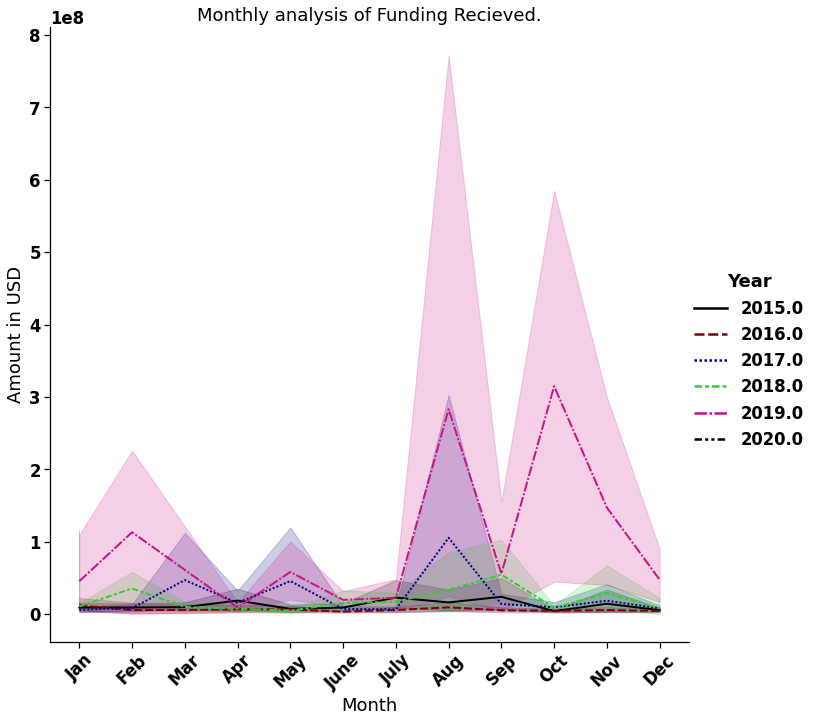

In [290]:
# Plot a line-plot to show the month-wise funding recieved.
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.relplot( height = 10,x = 'Month' , style = 'Year' ,kind = 'line', lw = 2, y = 'Amount in USD' , sort = col,  palette = ['black' , 'maroon' , 'navy' , 'limegreen' , 'mediumvioletred'], hue= 'Year', data = fund_df_temp)
plt.xticks(np.arange(1,13) , col , rotation = 45)
plt.title('Monthly analysis of Funding Recieved.')
plt.show()

### Yearwise funding recieved by startups.

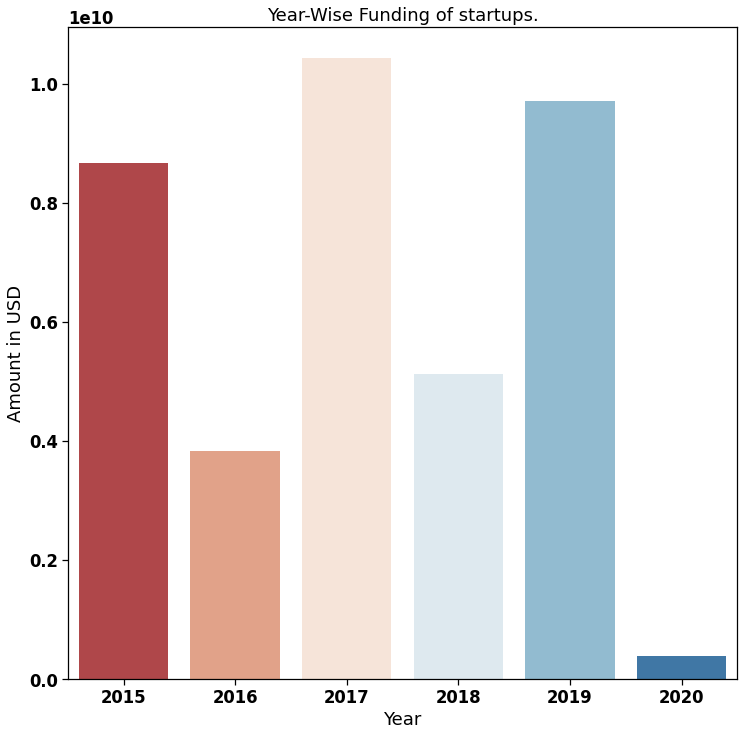

In [291]:
# Plot a bar plot to show the year wise funding recieved by startups.
plt.figure(figsize= (12,12))
plt.ylabel('Amount in USD')         
plt.xlabel('Year')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x = fund_df[::].index ,  y = [fund_df.loc[2015].values.sum() , fund_df.loc[2016].values.sum() , 
           fund_df.loc[2017].values.sum() , fund_df.loc[2018].values.sum() , fund_df.loc[2019].values.sum(),fund_df.loc[2020].values.sum()] , palette="RdBu" 
          ) 
plt.title('Year-Wise Funding of startups.')
plt.show()

### Top twenty startups which received the highest funding.

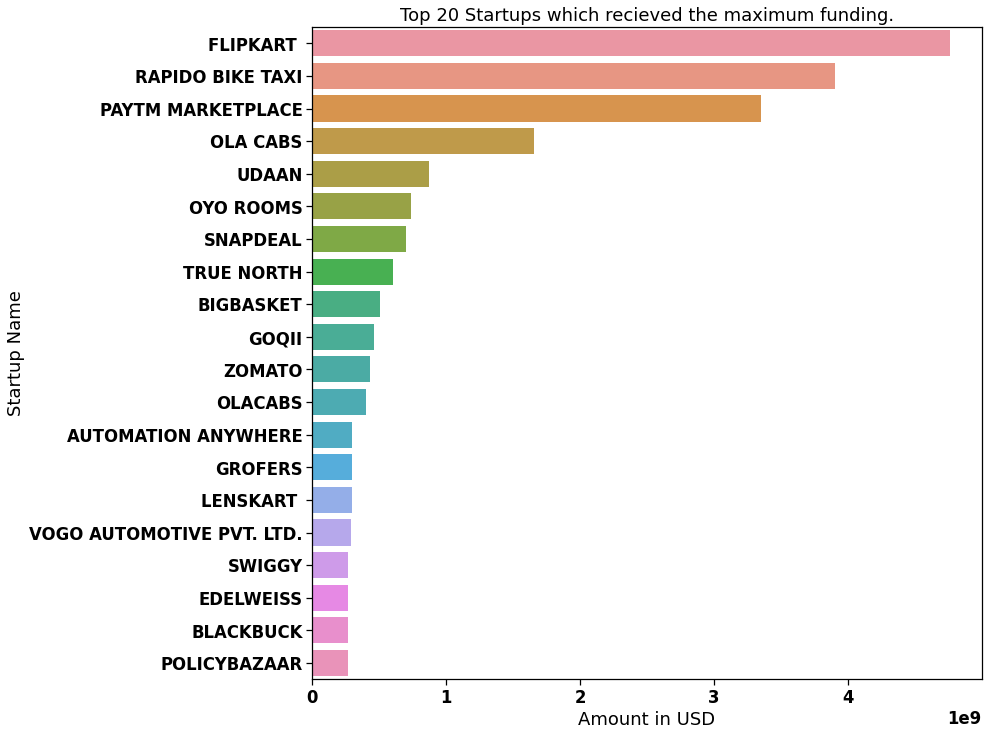

In [292]:
plt.figure(figsize=(12,12))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(y = data.groupby('Startup Name').sum().sort_values(by = 'Amount in USD' ,ascending = False)[:20]['Amount in USD'].index , x = 'Amount in USD' , data = data.groupby('Startup Name').sum().sort_values(by = 'Amount in USD' ,ascending = False)[:20]) 
plt.title('Top 20 Startups which recieved the maximum funding.')
plt.show()

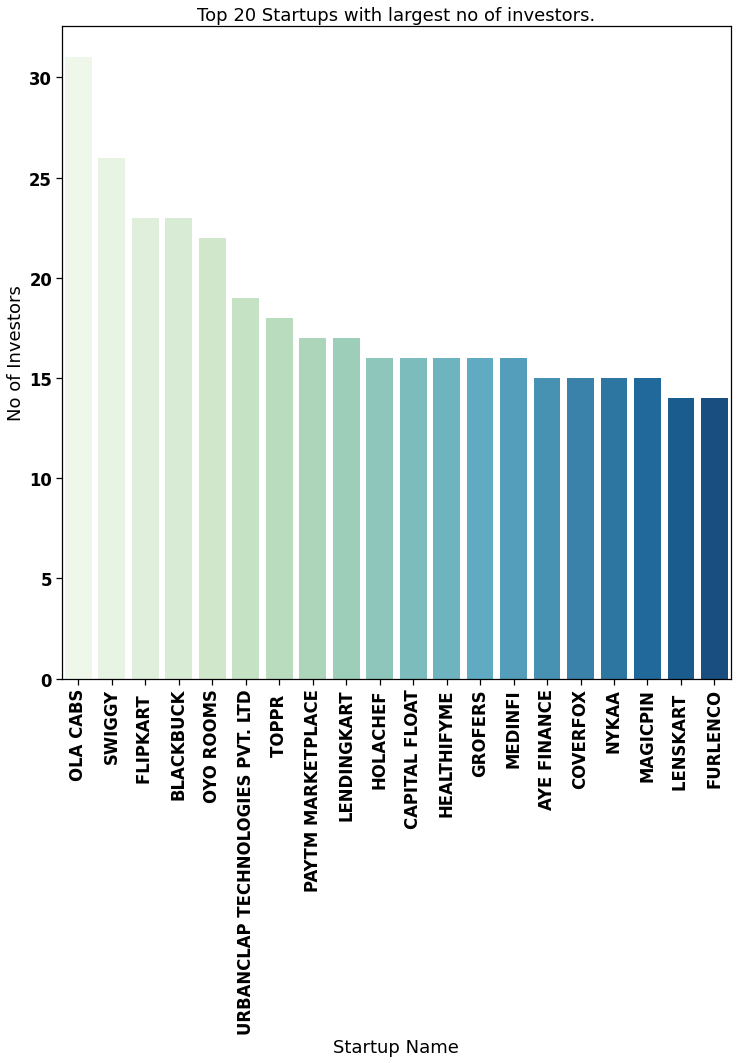

In [293]:
plt.figure(figsize=(12,12))
plt.xticks(rotation = 90)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x = data.groupby('Startup Name').count().sort_values(by = 'No of Investors' ,ascending = False)[:20]['Amount in USD'].index , palette='GnBu' , y = 'No of Investors' , data = data.groupby('Startup Name').sum().sort_values(by = 'No of Investors' ,ascending = False)[:20]) 
plt.title('Top 20 Startups with largest no of investors.' )
plt.show()

### Find the investors who made the maximum investment.

In [294]:
data.groupby('Investors Name').sum().sort_values(by = 'No of Investors' ,ascending = False)[:20]

,Amount in USD,No of Investors
Investors Name,,
"SEQUOIA CAPITAL INDIA, NORTH BASE MEDIA, AARIN CAPITAL, 3ONE4 CAPITAL, AXILOR VENTURES, KUNAL SHAH, SANDEEP TANDON",240888860.0,119
UNDISCLOSED INVESTORS AND TAMARIND FAMILY PRIVATE TRUST,966863951.0,105
"TIGER GLOBAL MANAGEMENT, BERTELSMANN INDIA, STEADVIEW CAPITAL, LIBERTY MEDIA, MOUSSE PARTNERS, QUILVEST",544000000.0,102
"SAIF PARTNERS, APRAMEYA RADHAKRISHNAN, PHANINDRA SAMA, SUBBA RAO TELIDEVARA, VIBHU GARG, PAULA RAVINDRA MARIWALA, GAURAV BHALOTIA",33200000.0,91
"KALAARI CAPITAL, QUALCOMM VENTURES, RUNET, ZODIUS TECHNOLOGY OPPORTUNITIES FUND,",26600000.0,70
"ACCEL PARTNERS, IDG VENTURE, ENDIYA PARTNERS, PI VENTURES, VH CAPITAL, AXILOR VENTURES AND BINNY BANSAL",135200000.0,66
"TRIFECTA CAPITAL ADVISORS LLP, PRATHITHI INVESTMENT TRUST, RNT CAPITAL, GOKUL RAJARAM, ADITYA AGARWAL, RUCHI SANGHVI AND OTHERS",48035089.0,60
"INDIAN ANGEL NETWORK (IAN), BEENEXT, THE CHENNAI ANGELS, SUNIL MUNJAL",8460000.0,56
"UNDISCLOSED JAPANESE INVESTOR, BERTELSMANN INDIA INVESTMENTS, NIRVANA DIGITAL INDIA FUND, NIRVANA DIGITAL INVESTMENT HOLDING CO LTD, 500 STARTUPS",37165000.0,55


In [295]:
# As we can see there are investors who made combined investment. 
# So, we try to find out the investors who made the maximum number of investment.

# Create a function to seperate the investors and store them 
investors_set = set()
def seperate_investors(series):

    for i in series.values:
        if re.search(',' , i):
            t_lst = i.split(',')
            for j in t_lst:
                investors_set.add(j)
        else:
            investors_set.add(i)
            
seperate_investors(data['Investors Name'])

# Now create a new dataframe.
investment_df = pd.DataFrame(columns=['Investor Name' , 'No of Investment'])
investment_df['No of Investment'] = investment_df['No of Investment'].astype('float') 
# Initialize the dataframe.
for i in investors_set:
    if i != '':
        investment_df = investment_df.append({'Investor Name':i , 'No of Investment':0} , ignore_index = True)
        
# Populate the dataframe.
for name in data['Investors Name']:
    if re.search(',', name):
        temp_lst = name.split(',')
        for nm in temp_lst:
            investment_df.loc[investment_df['Investor Name'] == nm , 'No of Investment'] += 1.0 
    else:
        investment_df.loc[investment_df['Investor Name'] == name , 'No of Investment']  += 1.0 
         
# investment_df[investment_df['Investor Name']== 'EQUITY CREST']['No of Investment'] = 3
investment_df.loc[investment_df['Investor Name']== 'EQUITY CREST' , 'No of Investment'] += 1  

In [296]:
investment_df.sort_values(by= 'No of Investment', ascending=False)[:20]['Investor Name']

1442    UNDISCLOSED INVESTORS AND TAMARIND FAMILY PRIV...
1043                                       ACCEL PARTNERS
1895                                      SEQUOIA CAPITAL
56                                         BLUME VENTURES
478                                               BEENEXT
6                                           SAIF PARTNERS
1036                                      KALAARI CAPITAL
1924                                      AXILOR VENTURES
1951                                       SANDEEP TANDON
344                                         SAIF PARTNERS
101                                       SEQUOIA CAPITAL
1736                              TIGER GLOBAL MANAGEMENT
440                                        ACCEL PARTNERS
137                                            KUNAL SHAH
2177                                    QUALCOMM VENTURES
1101                                      KALAARI CAPITAL
236                           LIGHTSPEED VENTURE PARTNERS
1590          

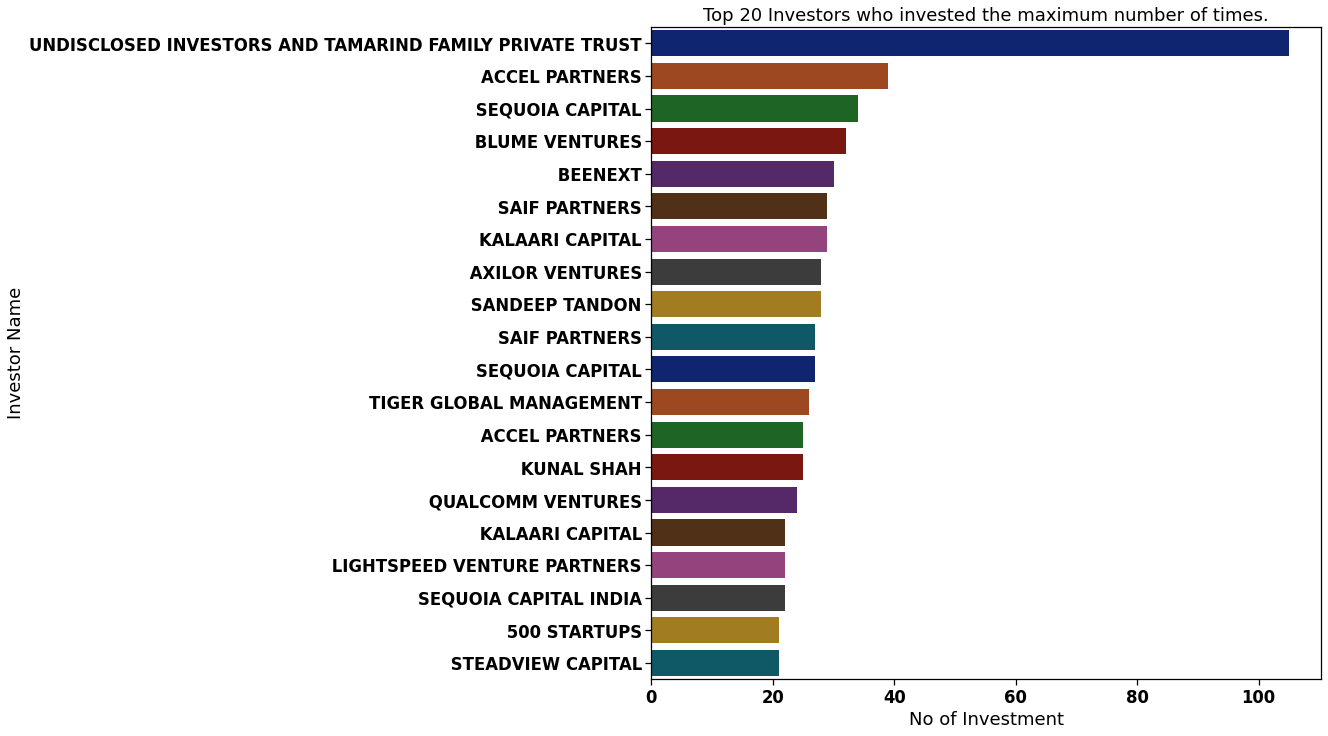

In [297]:
# Plot the graph
plt.figure(figsize=(12,12))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(y =investment_df.sort_values(by= 'No of Investment', ascending=False)[:20]['Investor Name'] , x = 'No of Investment' , data = investment_df.sort_values(by= 'No of Investment', ascending=False)[:20] , palette= 'dark') 
plt.title('Top 20 Investors who invested the maximum number of times.' )
plt.show()

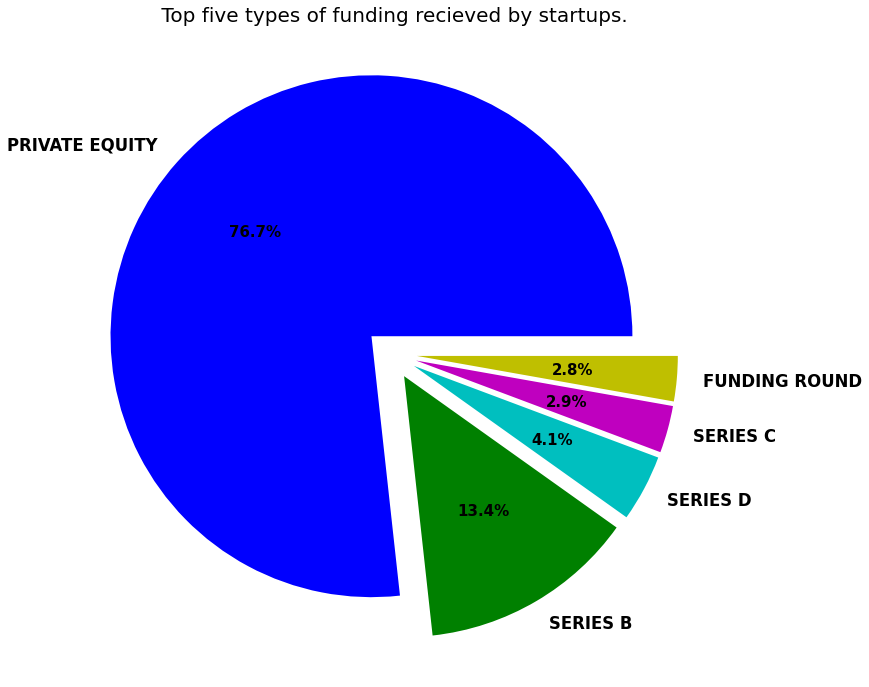

In [298]:
# Here we find the type of funding(top 5) recieved by startups.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
labels = data.groupby('InvestmentnType').sum().sort_values(by = 'Amount in USD' , ascending = False)[:5].index
values = data.groupby('InvestmentnType').sum().sort_values(by = 'Amount in USD' , ascending = False)[:5]['Amount in USD'].values
fig , ax = plt.subplots()
fig.set_size_inches(12,12)
ax.pie(colors = ['b' , 'g' , 'c' , 'm' , 'y'] ,  labels = labels , x = values , autopct='%.1f%%' , explode = [0.1 for x in range(5)])
plt.title(' Top five types of funding recieved by startups.' , fontsize = 20)
plt.show()

### Industry Verticals which recieved the maximum funding

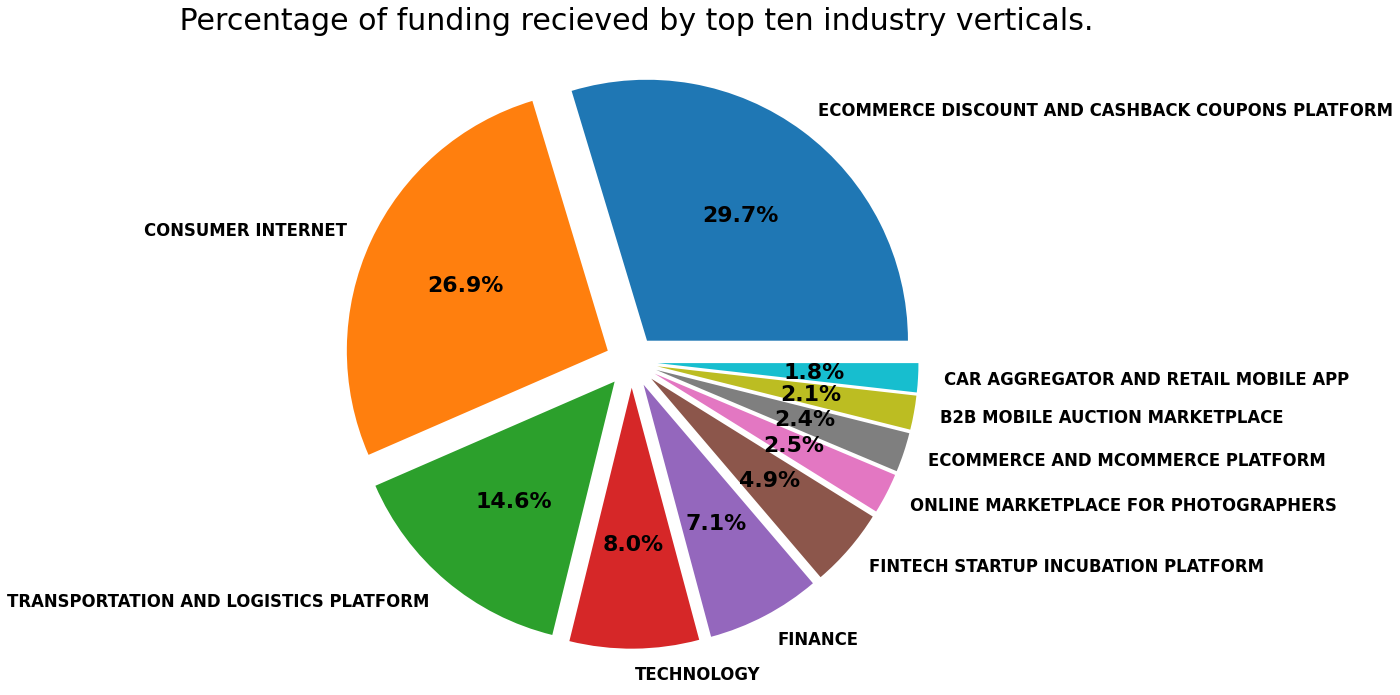

In [299]:
# Here we find the industry vertical which recieved the maximum funding.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
labels = data.groupby('Industry Vertical').sum().sort_values(by = 'Amount in USD' , ascending = False)[:10].index
values = data.groupby('Industry Vertical').sum().sort_values(by = 'Amount in USD' , ascending = False)[:10]['Amount in USD'].values
fig , ax = plt.subplots()
fig.set_size_inches(12,12)
ax.pie(  labels = labels , x = values , autopct='%.1f%%' , explode = [0.1 for x in range(10)])
plt.title(' Percentage of funding recieved by top ten industry verticals.' , fontsize = 30)
plt.show()

### Top Cities which recieved the maximum funding.

In [300]:
colors = ['#6987C2' ,'#947EB0' , '#A9D2D5' , '#ADFCF9' , '#4B644A' , '#2589BD' , '#E8AEB7' , '#58A4B0' , '#A9A587' ]
data.groupby('City  Location' ).sum().sort_values(by = 'Amount in USD' , ascending = False ).index

Index(['BENGALURU', 'MUMBAI', 'GURUGRAM', 'NEW DELHI', 'NOIDA', 'CHENNAI',
       'PUNE', 'MENLO PARK', 'HYDERABAD', 'INDIA', 'CALIFORNIA', 'KORMANGALA',
       'DELHI', 'FARIDABAD', 'TULANGAN', 'SAN FRANCISCO', 'JAIPUR',
       'SAN JOSE,', 'AHMEDABAD', 'SANTA MONICA', 'SINGAPORE', 'NEW YORK',
       'PALO ALTO', 'CHANDIGARH', 'TARAMANI', 'SURAT', 'BHUBNESWAR',
       'BURNSVILLE', 'USA', 'KOLKATA', 'HARYANA', 'UDUPI', 'VADODARA', 'GAYA',
       'ANDHERI', 'GOA', 'INDORE', 'COIMBATORE', 'KARNATAKA', 'BOSTON',
       'BENGALURU AND GURUGRAM', 'US', 'NAIROBI', 'SFO', 'ROURKELA', 'BHOPAL',
       'DELHI & CAMBRIDGE', 'NEW YORK, BENGALURU', 'LUCKNOW', 'DALLAS',
       'GWALIOR', 'PANAJI', 'BELGAUM', 'UDAIPUR', 'MISSOURIE', 'CHEMBUR',
       'AMRITSAR', 'KANPUR', 'JODHPUR', 'NAGPUR', 'TRIVANDRUM', 'VARANASI',
       'KERALA'],
      dtype='object', name='City  Location')

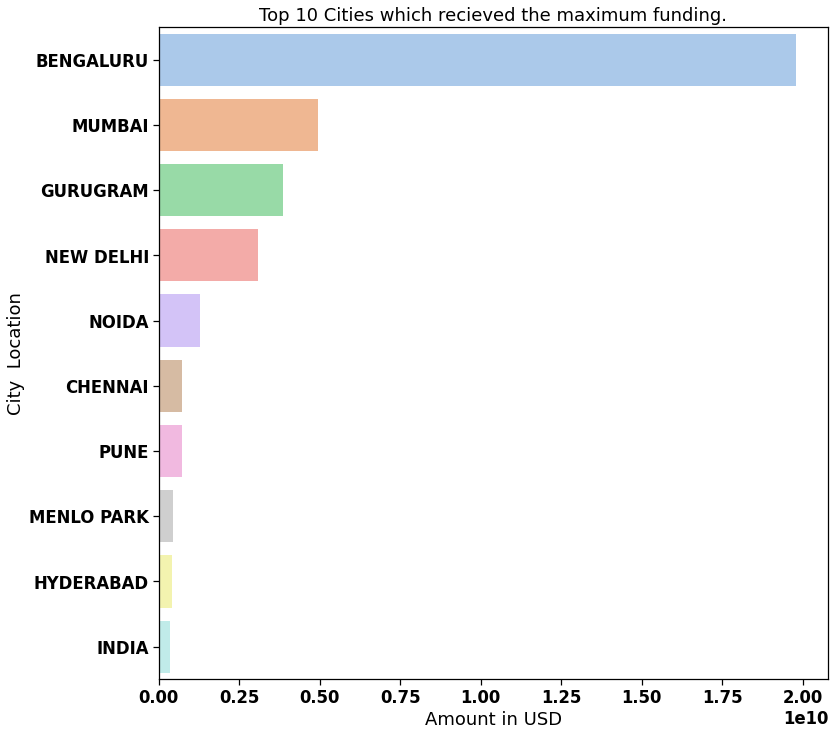

In [301]:
# We have to clean the data to avoid duplicity. 
data.loc[(data['City  Location'] == 'AHEMADABAD') | (data['City  Location'] == 'AHMEDABAD') , 'City  Location'] = 'AHMEDABAD'
data.loc[(data['City  Location'] == 'BANGALORE') | (data['City  Location'] == 'BENGALURU') , 'City  Location'] = 'BENGALURU'
data.loc[(data['City  Location'] == 'GURGAON') | (data['City  Location'] == 'GURUGRAM') , 'City  Location'] = 'GURUGRAM'

# Plot the data.
city_data = data.groupby('City  Location' ).sum().sort_values(by = 'Amount in USD' , ascending = False)[:10]
plt.figure(figsize=(12,12))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(y = city_data.index , x = 'Amount in USD' , data = city_data , palette= 'pastel') 
plt.title('Top 10 Cities which recieved the maximum funding.' )
plt.show()

### Top ten cities with maximum number of investors.

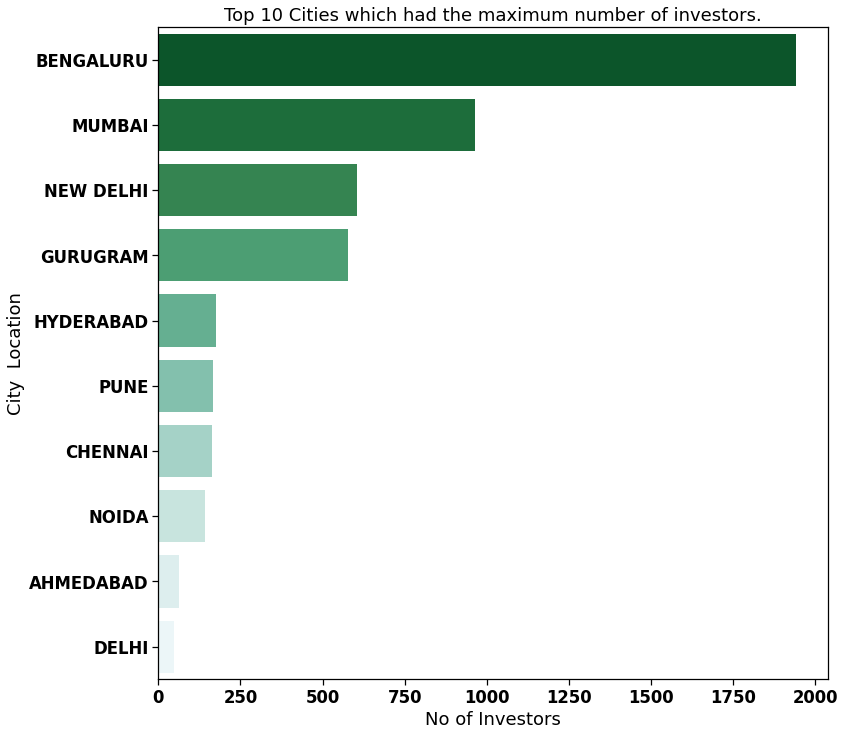

In [302]:
# Plot the data.
city_data = data.groupby('City  Location' ).sum().sort_values(by = 'No of Investors' , ascending = False)[:10]
plt.figure(figsize=(12,12))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(y = city_data.index , x = 'No of Investors' , data = city_data , palette= 'BuGn_r') 
plt.title('Top 10 Cities which had the maximum number of investors.' )
plt.show()

### Top ten cities with maximum number of startups.

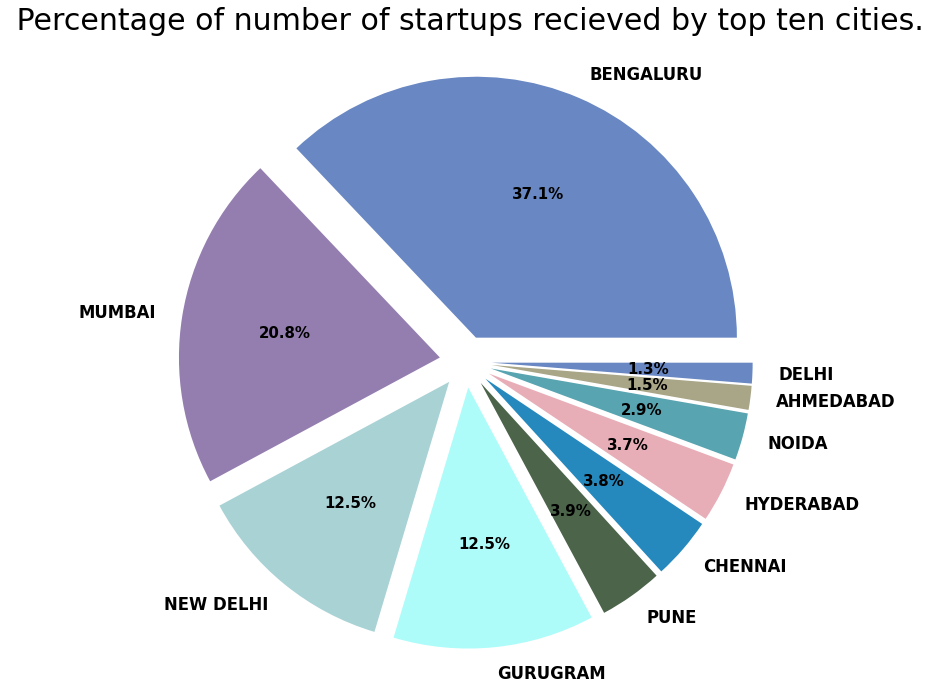

In [303]:
top_cities = data.groupby('City  Location' ).count().sort_values(by = 'Startup Name' , ascending = False)[:10]
# Here we find the industry vertical which recieved the maximum funding.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
labels = top_cities.index
values = top_cities['Startup Name'].values
fig , ax = plt.subplots()
fig.set_size_inches(12,12)
ax.pie(  colors = colors,labels = labels , x = values , autopct='%.1f%%' , explode = [0.1 for x in range(10)])
plt.title(' Percentage of number of startups recieved by top ten cities.' , fontsize = 30)
plt.show()

In [304]:
data.head(3)

,Date,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,No of Investors
0,2015-01-22,CORPORATE360,CONSUMER INTERNET,OTHERS,BENGALURU,GROUP OF ANGEL INVESTORS FROM US/INDIA,SEED FUNDING,200000.0,1
1,2015-01-15,WISHBERRY,CONSUMER INTERNET,OTHERS,BENGALURU,"RAJAN ANANDAN, SHANKAR MAHADEVAN, DEEP KALRA A...",SEED FUNDING,650000.0,3
2,2015-04-13,THE PORTER,LOGISTICS TECH PLATFORM,OTHERS,MUMBAI,"KAE CAPITAL, INDIA QUOTIENT, IFMR, AND MAS FIN...",SEED FUNDING,500000.0,4


In [305]:
data_m = data.drop(['Date','Startup Name','SubVertical','Investors Name','No of Investors'],axis=1)

In [306]:
data_m['Industry Vertical']=data_m['Industry Vertical'].value_counts()>5

In [307]:
data_m2 = pd.get_dummies(data_m,columns=['Industry Vertical','City  Location','InvestmentnType'],drop_first=True)

In [308]:
data_m2.head(20)

,Amount in USD,City Location_AMRITSAR,City Location_ANDHERI,City Location_BELGAUM,City Location_BENGALURU,City Location_BENGALURU AND GURUGRAM,City Location_BHOPAL,City Location_BHUBNESWAR,City Location_BOSTON,City Location_BURNSVILLE,...,InvestmentnType_SERIES E,InvestmentnType_SERIES F,InvestmentnType_SERIES G,InvestmentnType_SERIES H,InvestmentnType_SERIES J,InvestmentnType_SINGLE VENTURE,InvestmentnType_STRUCTURED DEBT,InvestmentnType_TERM LOAN,InvestmentnType_VENTURE - SERIES UNKNOWN,InvestmentnType_VENTURE ROUND
0,200000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,650000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,500000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2000000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,630000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,600000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8048394.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,9000000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,150000000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,200000000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(data_m2)

df_scaled = pd.DataFrame(df_scaled, columns=data_m2.columns)

In [310]:
df_scaled.head()

,Amount in USD,City Location_AMRITSAR,City Location_ANDHERI,City Location_BELGAUM,City Location_BENGALURU,City Location_BENGALURU AND GURUGRAM,City Location_BHOPAL,City Location_BHUBNESWAR,City Location_BOSTON,City Location_BURNSVILLE,...,InvestmentnType_SERIES E,InvestmentnType_SERIES F,InvestmentnType_SERIES G,InvestmentnType_SERIES H,InvestmentnType_SERIES J,InvestmentnType_SINGLE VENTURE,InvestmentnType_STRUCTURED DEBT,InvestmentnType_TERM LOAN,InvestmentnType_VENTURE - SERIES UNKNOWN,InvestmentnType_VENTURE ROUND
0,0.000047,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000163,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [311]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
x = data_m2.drop(['Amount in USD'],axis=1)
y = data_m2['Amount in USD']
x_train,x_test,y_train,y_test=train_test_split(x\
                ,y,test_size=0.30,random_state=42)

class Model_Selector():
    
    

    def __init__(self,n_estimators=100,\
            random_state=42,max_depth=10):
        print("Model Selector object created")
        
    """
    This method helps to select
    the best machine learning 
    model to compute the relationship
    betweem i/p and d/p variable
    
    """    
        
        
    def Regression_Model_Selector(self,df):
        seed = 42
        models = []
        models.append(("LR", LinearRegression()))
        models.append(("RF", RandomForestRegressor()))
        models.append(("KNN", KNeighborsRegressor()))
        models.append(("CART", DecisionTreeRegressor()))
        models.append(("XGB", XGBRegressor()))
        result = []
        names = []
        scoring = 'r2'
        seed = 42
        
        

        for name, model in models:
            kfold = KFold(n_splits = 5, shuffle=True)
            cv_results = cross_val_score(model, x_train,\
                    y_train, cv = kfold, scoring = scoring)
            result.append(cv_results)
            names.append(name)
            msg = (name, cv_results.mean(), cv_results.std())
            print(msg)
            
            
            
        fig = plt.figure(figsize = (8,4))
        fig.suptitle('Algorithm Comparison')
        ax = fig.add_subplot(1,1,1)
        plt.boxplot(result)
        ax.set_xticklabels(names)
        plt.show()

In [312]:
MS = Model_Selector()

Model Selector object created


('LR', -2.0090485858926602e+22, 3.937456947053817e+22)
('RF', -0.7633331249707228, 1.1786778100556596)
('KNN', -1.610947914969114, 2.7995847848057744)
('CART', -0.491999693596198, 0.795764934940277)
('XGB', -3.575151028866874, 5.975611195076058)


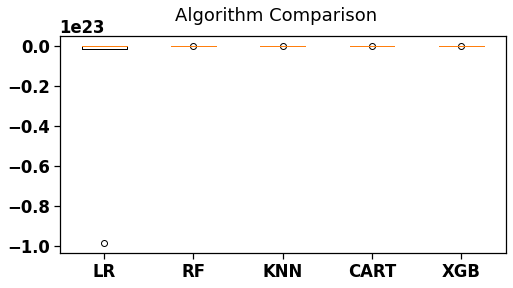

In [313]:
MS.Regression_Model_Selector(df_scaled)